# ORF recognition by Convolutional/Recurrent

Explore how to connect Dense layer after a LSTM layer.

Should there be a Flatten layer between them?

Should the last LSTM use return_sequences True or False?

Should the first Dense layer have a TimeDistributed wrapper? What about subsequent Dense layers?

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-26 15:42:22 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=32            # how long is each sequence
CDS_LEN=16            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 65 trials to reach 10 per class.
It took 142050 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 32.0
Average ORF length: 19.662363636363636
NC seqs
Average RNA length: 32.0
Average ORF length: 2.8334545454545457


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    #dnn.add(TimeDistributed(Dense(NEURONS,activation="sigmoid",dtype=np.float32)))   
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (32, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16, 16)            2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)           

LSTM(16,return_sequences=False), Dense(15) has 255 parameters. Acc=52%. Output shape is (None, 1). Output layer has 65 parameters: 8 * 8 + 1 so clearly it has one neuron.

LSTM(16,return_sequences=True), TimeDistributed(Dense(15)) has 255 parameters. Acc=65%. AUC fails because dimensions are wrong. Output shape is (None, 8, 1). The 8 is inherited from the Pooling layer and it is the revised sequence length. Output layer has 16 parameters: 8 + 8 so it seems to have 8 neurons despite parameter value 1. It seems the first TimeDistributed layer makes all subsequent Dense layers have 8 time steps. As an aside, the 8 values per sequence seem to converge on the eventual score per sequence. The series could be used to disect where the model decides coding! Also, the last value of an LSTM should be used without any Dense layer. 

LSTM(16,return_sequences=False), Dense(1) has 17 parameters. Acc=73% and still learning. As we learned above, the internal Dense layers are not necessary and may be hurting! (This model had no dropout. Unclear which layers should get dropout.)

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 43s 8ms/step - loss: 0.6671 - accuracy: 0.5752 - val_loss: 0.5860 - val_accuracy: 0.6894


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5664 - accuracy: 0.7077 - val_loss: 0.4892 - val_accuracy: 0.7654


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4773 - accuracy: 0.7729 - val_loss: 0.4328 - val_accuracy: 0.7984


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4144 - accuracy: 0.8121 - val_loss: 0.3746 - val_accuracy: 0.8267


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3618 - accuracy: 0.8361 - val_loss: 0.3323 - val_accuracy: 0.8517


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.3300 - accuracy: 0.8498 - val_loss: 0.3150 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3045 - accuracy: 0.8648 - val_loss: 0.3051 - val_accuracy: 0.8624


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2852 - accuracy: 0.8726 - val_loss: 0.2732 - val_accuracy: 0.8806


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2668 - accuracy: 0.8834 - val_loss: 0.2547 - val_accuracy: 0.8870


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2503 - accuracy: 0.8909 - val_loss: 0.2517 - val_accuracy: 0.8891


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2382 - accuracy: 0.8951 - val_loss: 0.2321 - val_accuracy: 0.8995


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2251 - accuracy: 0.9035 - val_loss: 0.2228 - val_accuracy: 0.9032


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2158 - accuracy: 0.9061 - val_loss: 0.2105 - val_accuracy: 0.9100


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2021 - accuracy: 0.9121 - val_loss: 0.2001 - val_accuracy: 0.9136


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1831 - accuracy: 0.9231 - val_loss: 0.1877 - val_accuracy: 0.9209


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1722 - accuracy: 0.9289 - val_loss: 0.1730 - val_accuracy: 0.9277


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1601 - accuracy: 0.9356 - val_loss: 0.1608 - val_accuracy: 0.9366


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1553 - accuracy: 0.9381 - val_loss: 0.1517 - val_accuracy: 0.9400


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1421 - accuracy: 0.9425 - val_loss: 0.1464 - val_accuracy: 0.9408


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1388 - accuracy: 0.9458 - val_loss: 0.1443 - val_accuracy: 0.9440


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1246 - accuracy: 0.9511 - val_loss: 0.1281 - val_accuracy: 0.9501


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1183 - accuracy: 0.9539 - val_loss: 0.1288 - val_accuracy: 0.9507


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1174 - accuracy: 0.9540 - val_loss: 0.1217 - val_accuracy: 0.9528


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1057 - accuracy: 0.9595 - val_loss: 0.1230 - val_accuracy: 0.9537


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0995 - accuracy: 0.9618 - val_loss: 0.1159 - val_accuracy: 0.9552


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0925 - accuracy: 0.9651 - val_loss: 0.1143 - val_accuracy: 0.9576


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0876 - accuracy: 0.9676 - val_loss: 0.0954 - val_accuracy: 0.9649


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0851 - accuracy: 0.9671 - val_loss: 0.0945 - val_accuracy: 0.9656


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0776 - accuracy: 0.9708 - val_loss: 0.1147 - val_accuracy: 0.9566
Epoch 30/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0762 - accuracy: 0.9712 - val_loss: 0.0914 - val_accuracy: 0.9632
Epoch 31/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0700 - accuracy: 0.9733 - val_loss: 0.0767 - val_accuracy: 0.9702


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0704 - accuracy: 0.9729 - val_loss: 0.0782 - val_accuracy: 0.9703


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0652 - accuracy: 0.9742 - val_loss: 0.0762 - val_accuracy: 0.9709


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0603 - accuracy: 0.9775 - val_loss: 0.0693 - val_accuracy: 0.9734


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0560 - accuracy: 0.9789 - val_loss: 0.0670 - val_accuracy: 0.9719
Epoch 36/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0553 - accuracy: 0.9789 - val_loss: 0.0622 - val_accuracy: 0.9762


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0493 - accuracy: 0.9811 - val_loss: 0.0705 - val_accuracy: 0.9737
Epoch 38/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0477 - accuracy: 0.9816 - val_loss: 0.0582 - val_accuracy: 0.9781


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0515 - accuracy: 0.9801 - val_loss: 0.0551 - val_accuracy: 0.9795


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0471 - accuracy: 0.9820 - val_loss: 0.0537 - val_accuracy: 0.9792
Epoch 41/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0412 - accuracy: 0.9838 - val_loss: 0.0564 - val_accuracy: 0.9769
Epoch 42/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0430 - accuracy: 0.9828 - val_loss: 0.0572 - val_accuracy: 0.9789
Epoch 43/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0384 - accuracy: 0.9839 - val_loss: 0.0464 - val_accuracy: 0.9827


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0347 - accuracy: 0.9858 - val_loss: 0.0521 - val_accuracy: 0.9804
Epoch 45/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0351 - accuracy: 0.9864 - val_loss: 0.0570 - val_accuracy: 0.9766
Epoch 46/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0365 - accuracy: 0.9847 - val_loss: 0.0574 - val_accuracy: 0.9804
Epoch 47/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0429 - accuracy: 0.9840 - val_loss: 0.0474 - val_accuracy: 0.9820
Epoch 48/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0457 - accuracy: 0.9831 - val_loss: 0.0479 - val_accuracy: 0.9814
Epoch 49/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0370 - accuracy: 0.9857 - val_loss: 0.0433 - val_accuracy: 0.9838


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0272 - accuracy: 0.9889 - val_loss: 0.0564 - val_accuracy: 0.9803
Fold 1, 50 epochs, 807 sec


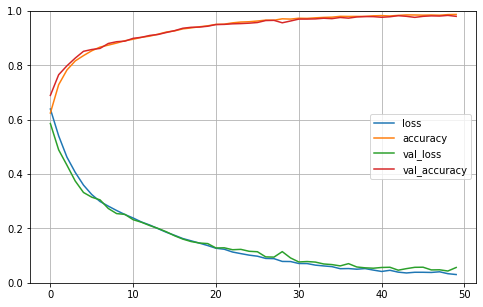

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 14s 8ms/step - loss: 0.6526 - accuracy: 0.5944 - val_loss: 0.5736 - val_accuracy: 0.6918
Epoch 2/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5363 - accuracy: 0.7218 - val_loss: 0.4464 - val_accuracy: 0.7911
Epoch 3/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.4109 - accuracy: 0.8102 - val_loss: 0.3632 - val_accuracy: 0.8335
Epoch 4/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.3488 - accuracy: 0.8413 - val_loss: 0.3227 - val_accuracy: 0.8596
Epoch 5/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.3028 - accuracy: 0.8661 - val_loss: 0.3011 - val_accuracy: 0.8680
Epoch 6/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.2732 - accuracy: 0.8810 - val_loss: 0.2784 - val_accuracy: 0.8795
Epoch 7/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.2409 - accu

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0351 - accuracy: 0.9865 - val_loss: 0.0377 - val_accuracy: 0.9872


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0294 - accuracy: 0.9887 - val_loss: 0.0446 - val_accuracy: 0.9841
Epoch 46/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0281 - accuracy: 0.9899 - val_loss: 0.0309 - val_accuracy: 0.9889


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 47/50
1334/1334 [==============================] - 11s 8ms/step - loss: 0.0196 - accuracy: 0.9928 - val_loss: 0.0277 - val_accuracy: 0.9902


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0194 - accuracy: 0.9928 - val_loss: 0.0311 - val_accuracy: 0.9888
Epoch 49/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0233 - accuracy: 0.9916 - val_loss: 0.0216 - val_accuracy: 0.9927


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0151 - accuracy: 0.9946 - val_loss: 0.0160 - val_accuracy: 0.9944


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 2, 50 epochs, 564 sec


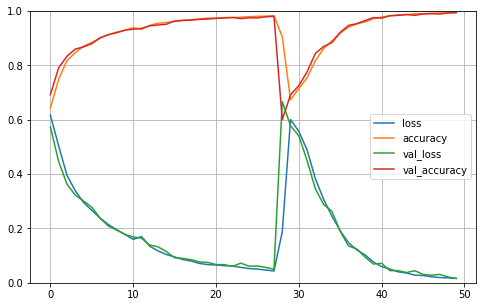

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 14s 8ms/step - loss: 0.6730 - accuracy: 0.5613 - val_loss: 0.5934 - val_accuracy: 0.6766
Epoch 2/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.5738 - accuracy: 0.6903 - val_loss: 0.5182 - val_accuracy: 0.7320
Epoch 3/50
1334/1334 [==============================] - 11s 8ms/step - loss: 0.4916 - accuracy: 0.7540 - val_loss: 0.4030 - val_accuracy: 0.8127
Epoch 4/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.3840 - accuracy: 0.8236 - val_loss: 0.3409 - val_accuracy: 0.8434
Epoch 5/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.3321 - accuracy: 0.8500 - val_loss: 0.3067 - val_accuracy: 0.8612
Epoch 6/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.3028 - accuracy: 0.8626 - val_loss: 0.2847 - val_accuracy: 0.8710
Epoch 7/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.2749 - accu

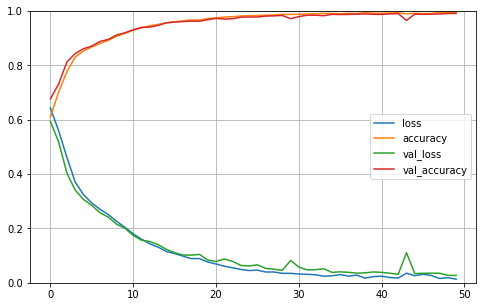

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 99.50%


predictions.shape (2000, 1)
first prediction [1.]


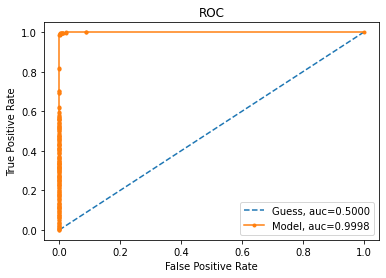

AUC: 99.98%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-26 16:14:19 UTC'